In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import os
import sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, match_coord, bgsmask

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Load GAMA DR4

In [2]:
gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

#get rid of stars in GAMA
Ngama = len(gama)
print('Percentage of Galaxies in GAMA Main Sample (z > 0.002): %.2f %%' %(100 * np.sum(gama['Z'] > 0.002)/Ngama))
print('Percentage of Stars in GAMA Main Sample (z < 0.002): %.2f %%' %(100 * np.sum(gama['Z'] < 0.002)/Ngama))

#
gama0 = gama #Include stars and galaxies in GAMA
gama = gama0[gama0['Z'] > 0.002] #Include only galaxies in GAMA


fraction of gama good quality: 186137 / 221373
Percentage of Galaxies in GAMA Main Sample (z > 0.002): 98.07 %
Percentage of Stars in GAMA Main Sample (z < 0.002): 1.93 %


# Load DR9 SWEEPS for GAMA footprint only (G12, G15, G09)

In [3]:
#
def gama12():
    
    return [174., 186., -3., 2.]

def gama15():
    
    return [211.5, 223.5, -2., 3.]

def gama09():
    
    return [129., 141., -2., 3.]

# load catalogue
# this is dr8 sweeps in decals with BGSBITS 


dr = 'dr9-south'
#dir where we are going to stored the results
pathdir = '/global/homes/q/qmxp55/DESI/bgstargets/doc/gama_%s' %(dr)
#if results dir does not exist, create it
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)
    
#get sweeps for GAMA footprint
lsin12 =  get_sweep_whole(patch=gama12(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=True, opt='2')
lsin15 =  get_sweep_whole(patch=gama15(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=True, opt='2')
lsin09 =  get_sweep_whole(patch=gama09(), dr=dr, rlimit=None, maskbitsource=False, bgsbits=True, opt='2')

# merge the SWEEPS in GAMA fileds targets in a single data frame
cat = np.concatenate((lsin12, lsin15, lsin09))


sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr9-south_sweep_174.0_186.0_-3.0_2.0.npy
Total run time: 0.000491 sec
sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr9-south_sweep_211.5_223.5_-2.0_3.0.npy
Total run time: 0.001401 sec
sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr9-south_sweep_129.0_141.0_-2.0_3.0.npy
Total run time: 0.000552 sec


In [55]:
cat.dtype.names

('RELEASE',
 'BRICKID',
 'BRICKNAME',
 'OBJID',
 'TYPE',
 'RA',
 'DEC',
 'GMAG',
 'RMAG',
 'ZMAG',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'SHAPE_R',
 'SHAPE_R_IVAR',
 'SHAPE_E1',
 'SHAPE_E1_IVAR',
 'SHAPE_E2',
 'SHAPE_E2_IVAR',
 'RFIBERMAG',
 'REF_CAT',
 'REF_ID',
 'G',
 'AEN',
 'MASKBITS',
 'FITBITS',
 'SERSIC',
 'SERSIC_IVAR',
 'FLUX_R',
 'BGSBITS')

In [4]:
#RANDOMS
dr = 'dr9'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
N = 3
ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy', mmap_mode='r+')

In [5]:
ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy', mmap_mode='r+')

In [6]:
# for healpy
import astropy.io.fits as fits
import healpy as hp
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
dr9pix = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/bright/pixweight-bright.fits'

if dr[:3] == 'dr8': pixfile = dr8pix
elif dr[:3] == 'dr9': pixfile = dr9pix
    
hdr          = fits.getheader(pixfile,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [7]:
#
from io_ import get_gama_fields
ran = ran[get_gama_fields(ran['RA'], ran['DEC'])]

In [8]:
ran_ex = ran_ex[get_gama_fields(ran_ex['RA'], ran_ex['DEC'])]

In [9]:
#
from cuts import getGeoCuts
rancuts = getGeoCuts(ran, randoms=True)

In [10]:
from io_ import get_dict
#Notes: This hpdict is used to get the area only using the randoms. 
#This use the randoms within the DESI footprint and without any masking (maskrand=None) as we want the area without wholes.
hpdict0 = get_dict(cat=None, pixmapfile=pixfile, hppix_ran=ran_ex['hppix'], hppix_cat=None, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])), 
                           maskcat=None, Nranfiles=N, ranindesi=ran_ex['desi'], catindesi=None, 
                                desifootprint=False, namesels=None, target_outputs=False, log=True)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  2700259
bgsfracarea DONE...
regions DONE...
area_all = 178 deg2
bgsarea_south = 178 deg2
bgsarea_decals = 178 deg2
bgsarea_des = 0 deg2
bgsarea_north = 0 deg2
bgsarea_south_n = 178 deg2
bgsarea_south_s = 0 deg2
bgsarea_svfields = 178 deg2
bgsarea_svfields_n = 0 deg2
bgsarea_svfields_s = 178 deg2
areas DONE...


# Match catalogues

In [11]:
#
def match(gama=None, cat=None):
    
    # matching LS8 with gama stars and galaxies
    idx2, idx1, d2d, d_ra, d_dec = match_coord(cat['RA'], cat['DEC'], 
                                                                gama['RA'], gama['DEC'], search_radius=1)

    # LS DR8 matched with gama
    dr8_gama = np.zeros_like(cat['RA'], dtype='?') #dr8 that match with gama
    dr8_z = np.full_like(cat['RA'], -1) #z from gama

    dr8_gama[idx2.tolist()] = True
    dr8_z[idx2.tolist()] = gama['Z'][idx1]
    
    return dr8_gama, dr8_z


In [12]:
#
dr8_gama, dr8_z = match(gama, cat)
#get BGS targets
bgs = ((cat['BGSBITS'] & 2**(20)) != 0) #| (L2) #adding the LSLGA galaxies
print('fraction of bgs in %s within GAMA: %i / %i' %(dr, np.sum(bgs), len(cat)))


Doubly matched objects = 1
Final matched objects = 182259
fraction of bgs in dr9 within GAMA: 262743 / 15862364


mean: 	 0.2246 (all) 	 0.2161 (bright) 	 0.2639 (faint)


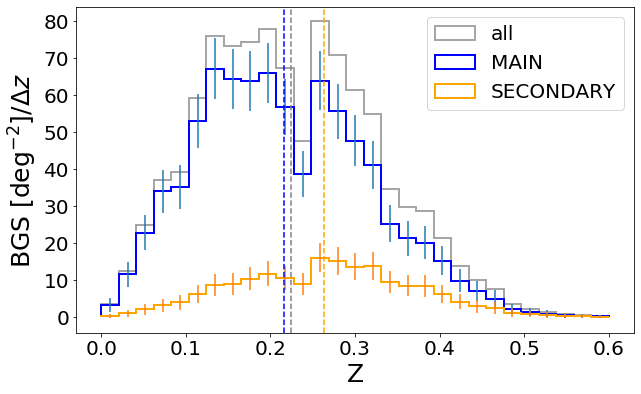

In [13]:
#
fig = plt.figure(figsize=(10,6))

N = np.sum((dr8_gama) & (bgs))
cumu = False
Ared = 175

mask = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (bgs)
maskB = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (cat['RMAG'] < 19.5) & (bgs)
maskF = (dr8_gama) & (dr8_z > 0) & (dr8_z < 0.8) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.) & (bgs)
bins = np.linspace(0,0.6,30)

#plt.title(r'BGS cross-matched with GAMA DR3', size=18)
h,e,p = plt.hist(dr8_z[mask], bins=bins,  weights=np.full(np.sum(mask), 1/Ared), histtype='step', cumulative=cumu, lw=2, color='gray', alpha=0.7, label='all')
hB,eB,pB = plt.hist(dr8_z[maskB], bins=bins,  weights=np.full(np.sum(maskB), 1/Ared), histtype='step', cumulative=cumu, lw=2, color='blue', label='MAIN')
hF,eF,pF = plt.hist(dr8_z[maskF], bins=bins,  weights=np.full(np.sum(maskF), 1/Ared), histtype='step', cumulative=cumu, lw=2, color='orange', label='SECONDARY')

#
plt.errorbar((eB[1:]+eB[:-1])/2., hB, np.sqrt(hB), fmt='none')
plt.errorbar((eF[1:]+eF[:-1])/2., hF, np.sqrt(hF), fmt='none')

print('mean: \t %.4f (all) \t %.4f (bright) \t %.4f (faint)' %(
    np.mean(dr8_z[mask]), np.mean(dr8_z[maskB]), np.mean(dr8_z[maskF])
    ))
plt.axvline(np.mean(dr8_z[mask]), ls='--', c='gray')
plt.axvline(np.mean(dr8_z[maskB]), ls='--', c='blue')
plt.axvline(np.mean(dr8_z[maskF]), ls='--', c='orange')

#plt.hist(dr8_z[(maskB) & (bgs)], bins=bins,  weights=np.full(np.sum((maskB) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='blue')
#plt.hist(dr8_z[(maskF) & (bgs)], bins=bins,  weights=np.full(np.sum((maskF) & (bgs)), 1/N), histtype='step', cumulative=cumu, lw=2, ls='--', color='orange')
plt.xlabel(r'Z', size=25)
plt.ylabel(r'BGS [deg$^{-2}$]/$\Delta z$', size=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

file = pathdir+'bgs_nz'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)


#

In [14]:
#get rid of objects within BS, NOBS and GC in GAMA

idx2, idx1, d2d, d_ra, d_dec = match_coord(cat['RA'], cat['DEC'], 
                                                            gama['RA'], gama['DEC'], search_radius=1)

mask = np.ones_like(cat, dtype=bool)
for i in ['BS', 'nobs', 'GC']:
    mask &= ((cat['BGSBITS'] & 2**(bgsmask()[i])) != 0)
    mask &= (cat['RMAG'] < 20)

gama_mask = np.ones_like(gama['RA'], dtype='?')
gama_mask[idx1.tolist()] = mask[idx2]

print('ratio of gama targets after / before these geometrical masks: \t %i / %i' %(np.sum(gama_mask), len(gama)))


Doubly matched objects = 1
Final matched objects = 182259
ratio of gama targets after / before these geometrical masks: 	 179822 / 182540


In [15]:
for num, (key, val) in enumerate(bgs_sce.items()):
    print(num, key, np.sum(val))

NameError: name 'bgs_sce' is not defined

In [53]:
#
from io_ import match_gama, gama_assess
from cuts import bgsbut

def get_gama_assess(cat=None, masks=None, gama=None, area=None, details=False):
    
    #fig = plt.figure(figsize=(20, 6))
    ls = ['-', '--', ':']
    #area = 60 * 3
    res_cumu = {}
    res_bin = {}
    
    ls_gama, gama_ls, ls_z = match_gama(cat=cat, gama=gama)
    gamagal = (ls_z > 0.002)
    ls_gama = (ls_gama) & (gamagal)
    
    #for num, key, cat, gama in zip(range(len(cats.keys())), cats.keys(), cats.values(), gamas.values()):
    for num, (key, val) in enumerate(masks.items()):
            
        #val = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['LG'], bgsmask=bgsmask(), rlimit=20)
        
        print('======================= RESULTS %s =======================' %(key))

        print('Total BGS: \t %.3f /deg^2' %(np.sum(val)/area))
        print('GAMA & LS: \t %.2f /deg^2'%(np.sum(ls_gama)/area))
        print('\t GAMA & LS & BGS : \t %.3f /deg^2' % (np.sum(val & ls_gama)/area))
        print('\t GAMA & LS & not in BGS : \t %.3f /deg^2' % (np.sum(~val & ls_gama)/area))
        tot = np.sum(~val & ls_gama)
        print('\t \t & rmag > 20 : \t %.3f %%' %(100 * np.sum((~val) & (ls_gama) & (cat['RMAG'] > 20))/tot))
        print('\t \t & rmag < 20 (rej by a BGS cut) : \t %.3f %%' %(100 * np.sum((~val) & (ls_gama) & (cat['RMAG'] < 20))/tot))
        
        if details:
            for key2, val2 in bgsmask().items():
                keep = ((cat['BGSBITS'] & 2**(val2)) == 0)
                print('\t \t \t & %s : \t %.3f %%' %(key2, np.sum((~val) & (ls_gama) & (cat['RMAG'] < 20) & (keep))/area))

        rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot = gama_assess(cat=cat, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val, cumu=False)
        res_bin[key] = np.array([rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot])
        
        rmagl_c, Ncomp_c, Ncont_c, Nincomp_c, Ngama_ls_c, Ntot_c = gama_assess(cat=cat, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val, cumu=True)
        res_cumu[key] = np.array([rmagl_c, Ncomp_c, Ncont_c, Nincomp_c, Ngama_ls_c, Ntot_c])
        
    return res_bin, res_cumu


In [17]:
#
def plot_gama_assess(res_bin, res_cumu, comp=True, kind=2, savefile=None):
    
    fig = plt.figure(figsize=(10, 5))
    cols = ['k', 'orange', 'blue', 'red', 'pink']
    
    if kind == 0: res_dicts = [res_cumu]
    elif kind == 1: res_dicts = [res_bin]
    elif kind == 2: res_dicts = [res_bin, res_cumu]
    else: raise ValueError('kind = %i is not a valid option.' %(kind))
    
    for i, res in enumerate(res_dicts):
        
        if i == 0: ls = '-'
        elif i == 1: ls = '--'
        
        for num, (key, val) in enumerate(res.items()):

            rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot = val

            if comp:
                plt.title('COMPLETENESS', size=15)
                plt.plot(rmagl, Ncomp/Ngama_ls, ls=ls, color=cols[num], label='%s' %(key) if i == 0 else None)
                plt.ylabel(r'$f$=(BGS & gama_gal)/gama_gal', size=18)
                plt.ylim(0.98, 1.01)
                if kind == 2:
                    plt.text(14.5, 0.985, 'solid: binned', size=12)
                    plt.text(14.5, 0.983, 'dashed: cumulative', size=12)
            else:
                plt.title('CONTAMINATION', size=15)
                plt.plot(rmagl, Ncont/Ngama_ls, ls=ls, color=cols[num], label='%s' %(key) if i == 0 else None)
                plt.ylabel(r'$f$=(BGS & ~gama_gal)/gama_gal', size=18)
                plt.ylim(0, 1.5)
                if kind == 2:
                    plt.text(17, 1.2, 'solid: binned', size=12)
                    plt.text(17, 1.3, 'dashed: cumulative', size=12)
            
    plt.legend(fontsize=12)
    plt.axvspan(19.0, 20.0, alpha=0.3, color='red')
    plt.axhline(1, ls='--', c='k')
    plt.axvline(19.0, ls=':', label='19.0', color='k')
    plt.xlabel(r'$r_{mag}$', size=22)
    plt.xlim(14, 20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()
    
    if savefile is not None:
        fig.savefig(savefile+'.png', bbox_inches = 'tight', pad_inches = 0)
    

In [18]:
res_bin, res_cumu = get_gama_assess(cat=cat, masks={'BGS':bgs}, gama=gama[gama_mask], area=hpdict0['area_all'])

Doubly matched objects = 1
Final matched objects = 179541
======================= RESULTS BGS =======================
Total BGS: 	 1474.409 /deg^2
GAMA & LS: 	 1007.51 /deg^2
	 GAMA & LS & BGS : 	 995.207 /deg^2
	 GAMA & LS & not in BGS : 	 12.306 /deg^2
	 	 & rmag > 20 : 	 0.000 %
	 	 & rmag < 20 (rej by a BGS cut) : 	 100.000 %


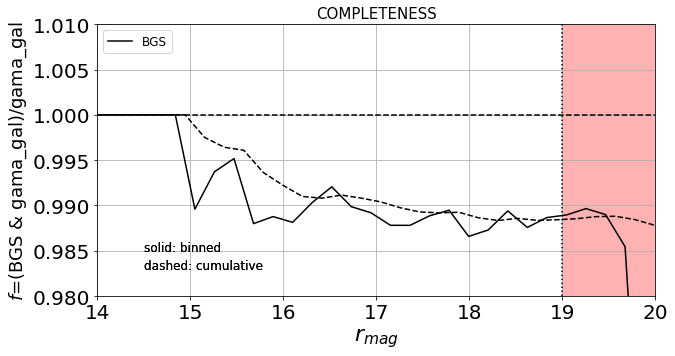

In [19]:
plot_gama_assess(res_bin, res_cumu, comp=True, kind=2, savefile=os.path.join(pathdir, 'gama_assess_comp'))

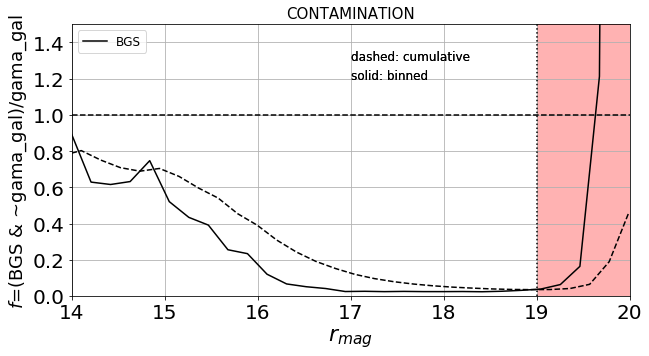

In [20]:
plot_gama_assess(res_bin, res_cumu, comp=False, savefile=os.path.join(pathdir, 'gama_assess_cont'))

In [21]:
def get_bars_gama(labels=None, cats=None, gamas=None, bgsmask=None, log=False, width=None, figsize=(30,10), title=None):
        
    #labels = ['BS', 'MS', 'LG', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    rects = {}

    x = np.arange(len(labels))  # the label locations
    if width is None: width = 0.3  # the width of the bars
    delta = 0

    fig, ax = plt.subplots(figsize=figsize)
    
    rejs_all = {}

    for num, key, cat, gama in zip(range(len(cats.keys())), cats.keys(), cats.values(), gamas.values()):
    
        ls_gama, gama_ls, ls_z = match_gama(cat=cat, gama=gama)
        gamagal = (ls_z > 0.002)
        
        rejs = []
        for i in labels:
            bgsbut_ = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=[i], bgsmask=bgsmask, rlimit=20)
            rej = ((cat['BGSBITS'] & 2**(bgsmask[i])) != 0)
            pb = (bgsbut_) & (~rej)
            rejs.append(np.sum((ls_gama) & (pb))/np.sum(pb))
            
            rejs_all['pb_%s_%s' %(key, i)] = pb
            rejs_all['pbgama_%s_%s' %(key, i)] = (~ls_gama) & (pb)
            
        #val = [np.sum((bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=[i], bgsmask=bgsmask(), rlimit=20)) & ~((cat['BGSBITS'] & 2**(bgsmask[i])) != 0) & ()) for i in labels]
        
        rects[key] = ax.bar(x - 1*width + delta, rejs, width, label=key)
        delta += width

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('gama & PB / PB', size=30)
    if title is not None: ax.set_title(title, size=30)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=30, rotation=45)
    ax.legend(fontsize=15)
    if log: ax.set_yscale('log')

    for i in rects.keys():
        #autolabel(i)
        #print(i)
        #autolabel(rects[i])
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects[i]:
            height = rect.get_height()
            ax.annotate('{}'.format(np.round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 3, height),
                        xytext=(3, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    fig.tight_layout()

    plt.show()
    
    return rejs_all

Doubly matched objects = 1
Final matched objects = 179541


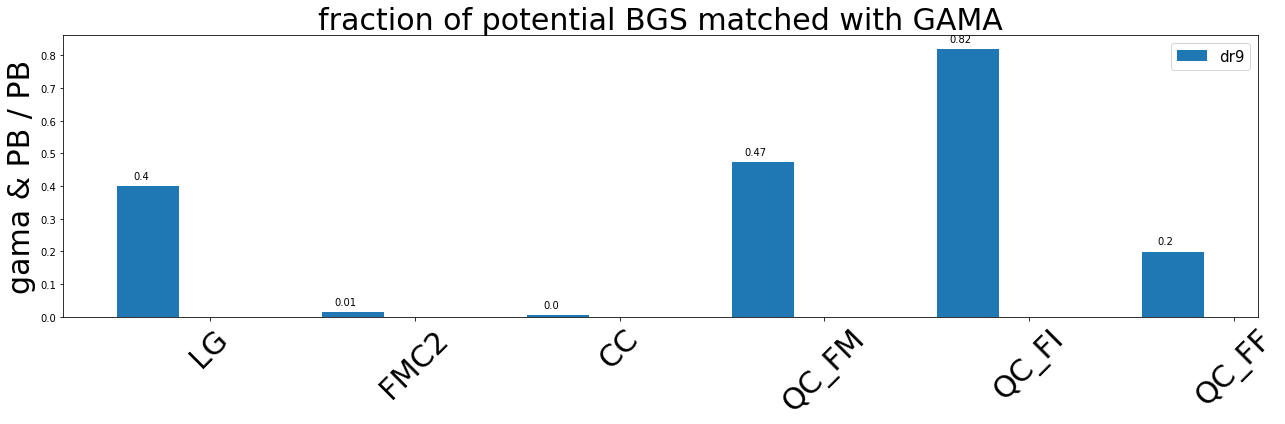

In [22]:
#
labels = ['LG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
rejs_all = get_bars_gama(labels=labels, cats={'dr9':cat}, gamas={'gama':gama[gama_mask]}, bgsmask=bgsmask(), title='fraction of potential BGS matched with GAMA', figsize=(18,6))

## BGS Scenarios

In [44]:
for key, val in bgsmask().items():
    print(key, np.sum(((cat['BGSBITS'] & 2**(val)) == 0)))

BS 115714
MS 663601
GC 0
LG 29471
allmask 78170
nobs 8724
SG 891506
SGSV 884398
FMC 68782
FMC2 66730
CC 735812
QC_FM 142851
QC_FI 13228
QC_FF 464506
QC_FM2 54563
QC_FI2 3093
QC_FF2 222330
QC_IVAR 8895
bgs_any 15599621
bgs_bright 15708782
bgs_faint 15753203
bgs_sv_any 15406897
bgs_sv_bright 15703694
bgs_sv_faint 15719574
bgs_sv_faint_ext 15741960
bgs_sv_fibmag 15829853
bgs_sv_lowq 15856457


In [25]:
#
bgsbut_fracs_but_lg = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF', 'LG'], bgsmask=bgsmask(), rlimit=20)
bgsbut_lg = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['LG'], bgsmask=bgsmask(), rlimit=20)

fracs_re = np.ones_like(cat, dtype=bool)
for i in (14,15,16): 
    fracs_re &= ((cat['BGSBITS'] & 2**(i)) != 0)

bgs_sce = {}

bgs_sce['nominal DR8'] = ((cat['BGSBITS'] & 2**(20)) != 0)
bgs_sce['no LG old Fracs'] = bgsbut_lg
bgs_sce['no Fracs and no LG'] = bgsbut_fracs_but_lg
bgs_sce['nominal DR9'] = (bgsbut_fracs_but_lg) & (fracs_re) #new_fracs_no_LG


In [26]:
#
for key,val in bgs_sce.items():
    print(key, np.round(np.sum(val)/hpdict0['area_all'], 2))

nominal DR8 1474.41
no LG old Fracs 1482.59
no Fracs and no LG 1500.21
nominal DR9 1493.69


In [34]:
#
print('Percentage of GAMA & LS / GAMA: \t %.2f %%' %(100 * 1007.51 / (np.sum(gama_mask)/hpdict0['area_all'])))

Percentage of GAMA & LS / GAMA: 	 99.84 %


In [54]:
#
bgs_sce2 = {}
bgs_sce2['nominal DR9'] = (bgsbut_fracs_but_lg) & (fracs_re) #new_fracs_no_LG

res_bin_sce2, res_cumu_sce2 = get_gama_assess(cat=cat, masks=bgs_sce2, gama=gama[gama_mask], area=hpdict0['area_all'], details=True)

Doubly matched objects = 1
Final matched objects = 179541
======================= RESULTS nominal DR9 =======================
Total BGS: 	 1493.685 /deg^2
GAMA & LS: 	 1007.51 /deg^2
	 GAMA & LS & BGS : 	 1002.990 /deg^2
	 GAMA & LS & not in BGS : 	 4.523 /deg^2
	 	 & rmag > 20 : 	 0.000 %
	 	 & rmag < 20 (rej by a BGS cut) : 	 100.000 %
	 	 	 & BS : 	 0.000 %
	 	 	 & MS : 	 0.595 %
	 	 	 & GC : 	 0.000 %
	 	 	 & LG : 	 0.107 %
	 	 	 & allmask : 	 0.073 %
	 	 	 & nobs : 	 0.000 %
	 	 	 & SG : 	 3.822 %
	 	 	 & SGSV : 	 1.981 %
	 	 	 & FMC : 	 0.079 %
	 	 	 & FMC2 : 	 0.039 %
	 	 	 & CC : 	 0.039 %
	 	 	 & QC_FM : 	 0.174 %
	 	 	 & QC_FI : 	 0.079 %
	 	 	 & QC_FF : 	 0.466 %
	 	 	 & QC_FM2 : 	 0.135 %
	 	 	 & QC_FI2 : 	 0.051 %
	 	 	 & QC_FF2 : 	 0.449 %
	 	 	 & QC_IVAR : 	 0.028 %
	 	 	 & bgs_any : 	 4.523 %
	 	 	 & bgs_bright : 	 4.523 %
	 	 	 & bgs_faint : 	 4.523 %
	 	 	 & bgs_sv_any : 	 1.981 %
	 	 	 & bgs_sv_bright : 	 2.654 %
	 	 	 & bgs_sv_faint : 	 3.883 %
	 	 	 & bgs_sv_faint_

In [27]:
res_bin_sce, res_cumu_sce = get_gama_assess(cat=cat, masks=bgs_sce, gama=gama[gama_mask], area=hpdict0['area_all'])

Doubly matched objects = 1
Final matched objects = 179541
======================= RESULTS nominal DR8 =======================
Total BGS: 	 1474.409 /deg^2
GAMA & LS: 	 1007.51 /deg^2
	 GAMA & LS & BGS : 	 995.207 /deg^2
	 GAMA & LS & not in BGS : 	 12.306 /deg^2
	 	 & rmag > 20 : 	 0.000 %
	 	 & rmag < 20 (rej by a BGS cut) : 	 100.000 %
======================= RESULTS no LG old Fracs =======================
Total BGS: 	 1482.591 /deg^2
GAMA & LS: 	 1007.51 /deg^2
	 GAMA & LS & BGS : 	 998.473 /deg^2
	 GAMA & LS & not in BGS : 	 9.040 /deg^2
	 	 & rmag > 20 : 	 0.000 %
	 	 & rmag < 20 (rej by a BGS cut) : 	 100.000 %
======================= RESULTS no Fracs and no LG =======================
Total BGS: 	 1500.212 /deg^2
GAMA & LS: 	 1007.51 /deg^2
	 GAMA & LS & BGS : 	 1003.618 /deg^2
	 GAMA & LS & not in BGS : 	 3.894 /deg^2
	 	 & rmag > 20 : 	 0.000 %
	 	 & rmag < 20 (rej by a BGS cut) : 	 100.000 %
======================= RESULTS nominal DR9 =======================
Total BGS: 	 1493.

In [37]:
pathdir

'/global/homes/q/qmxp55/DESI/bgstargets/doc/gama_dr9-south'

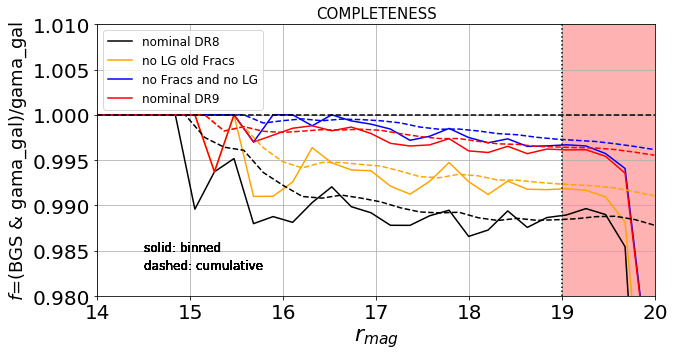

In [28]:
plot_gama_assess(res_bin_sce, res_cumu_sce, comp=True, kind=2, savefile=os.path.join(pathdir, 'gama_assess_comp_bgs_sce'))

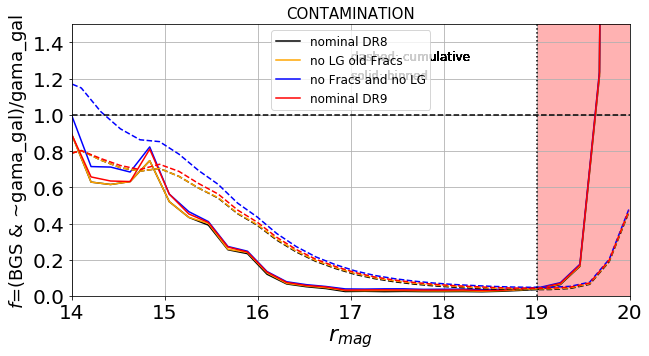

In [29]:
plot_gama_assess(res_bin_sce, res_cumu_sce, comp=False, kind=2, savefile=os.path.join(pathdir, 'gama_assess_cont_bgs_sce'))


# Save GAMA matched for above BGS catalogues

In [37]:
#
gama_matched = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/gama/GAMA_matched_new_fracs_no_LG.npy')

ingama = gama_matched['inGAMA']
z = gama_matched['Z'][ingama]

#bgs = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/south_new_fracs_no_LG.npy')


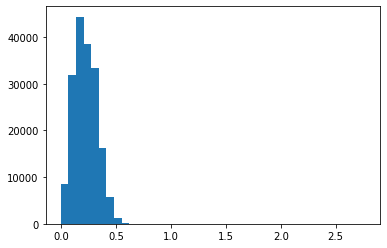

In [39]:
plt.hist(z, 40)
plt.show()

In [28]:
cat = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/south_new_fracs_no_LG.npy')

In [29]:
gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]

In [30]:
def get_isgama(ra, dec):
    
    keep = np.zeros_like(ra, dtype='?')

    keep |= ((ra > 174.) & (ra < 186.) & (dec > -3.) & (dec < 2.)) #G12
    keep |= ((ra > 211.5) & (ra < 223.5) & (dec > -2.) & (dec < 3.)) #G15
    keep |= ((ra > 129.) & (ra < 141.) & (dec > -2.) & (dec < 3.)) #G09
    
    return keep

In [31]:
for col in gama.dtype.names:
    print(col)

CATAID
OBJID
RA
DEC
FIBERMAG_R
R_PETRO
U_MODEL
G_MODEL
R_MODEL
I_MODEL
Z_MODEL
SURVEY_CODE
Z
NQ
NQ2_FLAG
SPECID
VEL_ERR
NUM_GAMA_SPEC
R_SB
SG_SEP
SG_SEP_JK
K_AUTO
RADIO_FLUX
HATLAS_FLAG
AREA_FLAG
TARGET_FLAGS
SURVEY_OLDCLASS
SURVEY_CLASS
PRIORITY_CLASS
NEIGHBOUR_CLASS
TC_V11_ID
MASK_IC_10
MASK_IC_12
VIS_CLASS
VIS_CLASS_USER


In [32]:
def match(cat=None, gama=None):
    
    # matching LS8 with gama stars and galaxies
    idx20, idx10, d2d0, d_ra0, d_dec0 = search_around(cat['RA'], cat['DEC'], 
                                                                gama['RA'], gama['DEC'], search_radius=1)
    
    tabGAMA = Table()
    
    cat_gama = np.zeros_like(cat['RA'], dtype='?') #dr8 that match with gama
    cat_gama2 = np.full_like(cat['RA'], np.nan) #z from gama
    cat_gama3 = np.full_like(cat['RA'], np.nan, dtype=str) #z from gama
    
    cat_gama[idx20.tolist()] = True
    tabGAMA['inGAMA'] = cat_gama

    for col in gama.dtype.names:
        
        print(col)
        #float, int, str, list, dict, tuple
        if isinstance(gama[col][0], (str)): cat0 = cat0 = cat_gama3.copy()
        else: cat0 = cat_gama2.copy()
            
        cat0[idx20.tolist()] = gama[col][idx10]
        tabGAMA[col] = cat0
    
    return tabGAMA


In [33]:
from io_ import search_around
from astropy.table import Table

In [34]:
#match catalogue with GAMA
Agama = 180.
#mask = cat['RMAG'] < 15
tabGAMA = match(cat=cat, gama=gama)

gamastars8 = (tabGAMA['Z'] < 0.002) & (tabGAMA['Z'] > 0) & (tabGAMA['inGAMA'])
gamagal8 = (tabGAMA['Z'] > 0.002) & (tabGAMA['inGAMA'])

print('GAMA in DR8: \t %.3f(stars) \t %.3f(galaxies)' %(np.sum(gamastars8)/Agama,np.sum(gamagal8)/Agama))


179860 nearby objects
CATAID
OBJID
RA
DEC
FIBERMAG_R
R_PETRO
U_MODEL
G_MODEL
R_MODEL
I_MODEL
Z_MODEL
SURVEY_CODE
Z
NQ
NQ2_FLAG
SPECID
VEL_ERR
NUM_GAMA_SPEC
R_SB
SG_SEP
SG_SEP_JK
K_AUTO
RADIO_FLUX
HATLAS_FLAG
AREA_FLAG
TARGET_FLAGS
SURVEY_OLDCLASS
SURVEY_CLASS
PRIORITY_CLASS
NEIGHBOUR_CLASS
TC_V11_ID
MASK_IC_10
MASK_IC_12
VIS_CLASS
VIS_CLASS_USER
GAMA in DR8: 	 0.661(stars) 	 998.028(galaxies)


In [35]:
tabGAMA

inGAMA,CATAID,OBJID,RA,DEC,FIBERMAG_R,R_PETRO,U_MODEL,G_MODEL,R_MODEL,I_MODEL,Z_MODEL,SURVEY_CODE,Z,NQ,NQ2_FLAG,SPECID,VEL_ERR,NUM_GAMA_SPEC,R_SB,SG_SEP,SG_SEP_JK,K_AUTO,RADIO_FLUX,HATLAS_FLAG,AREA_FLAG,TARGET_FLAGS,SURVEY_OLDCLASS,SURVEY_CLASS,PRIORITY_CLASS,NEIGHBOUR_CLASS,TC_V11_ID,MASK_IC_10,MASK_IC_12,VIS_CLASS,VIS_CLASS_USER
bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1
False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n
False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n
False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n
False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n
False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n
False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n
False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n
False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n
False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n


In [36]:
# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/gama/GAMA_matched_new_fracs_no_LG'
np.save(dest, tabGAMA)